# Analisis del dataset

Este notebook ....

📁 Category: screw

📂 ESTRUCTURA DEL DATASET

🟢 TRAIN SET:
  - good: 320 imágenes

🔴 TEST SET:
  - scratch_head: 24 imágenes
  - thread_top: 23 imágenes
  - good: 41 imágenes
  - thread_side: 23 imágenes
  - manipulated_front: 24 imágenes
  - scratch_neck: 25 imágenes

🎯 GROUND TRUTH:
  - scratch_head: 24 máscaras
  - thread_top: 23 máscaras
  - thread_side: 23 máscaras
  - manipulated_front: 24 máscaras
  - scratch_neck: 25 máscaras

📊 RESUMEN:
  Total Train: 320
  Total Test: 160
  Total: 480



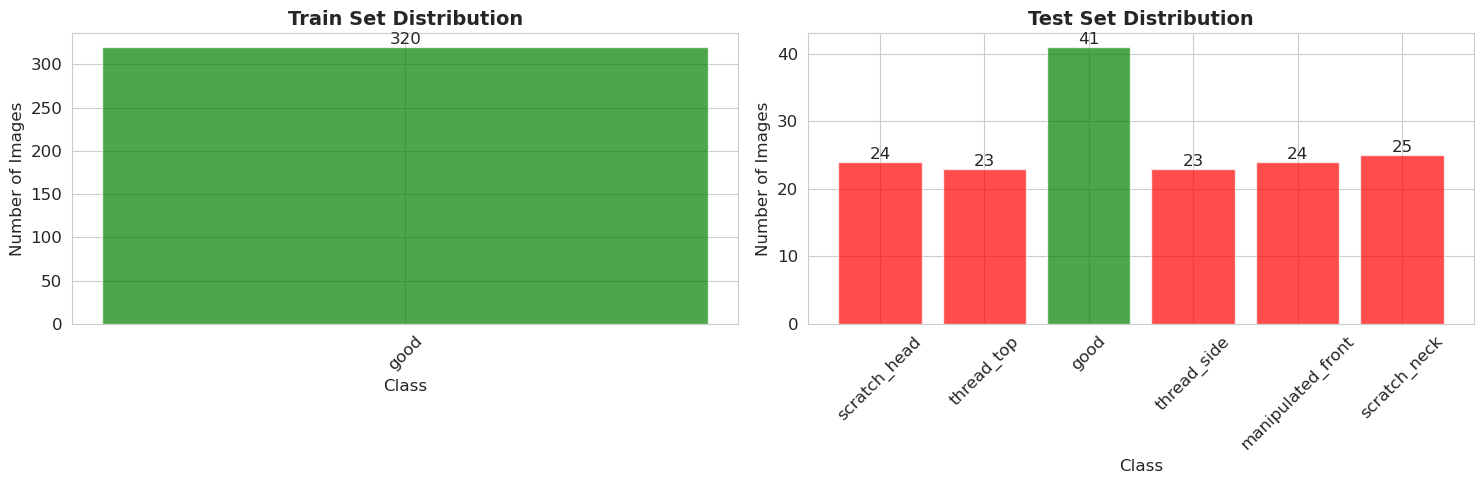


⚠️  ANÁLISIS DE DESBALANCE:
  Good: 41
  Defects: 119
  Ratio (Defects/Good): 2.90


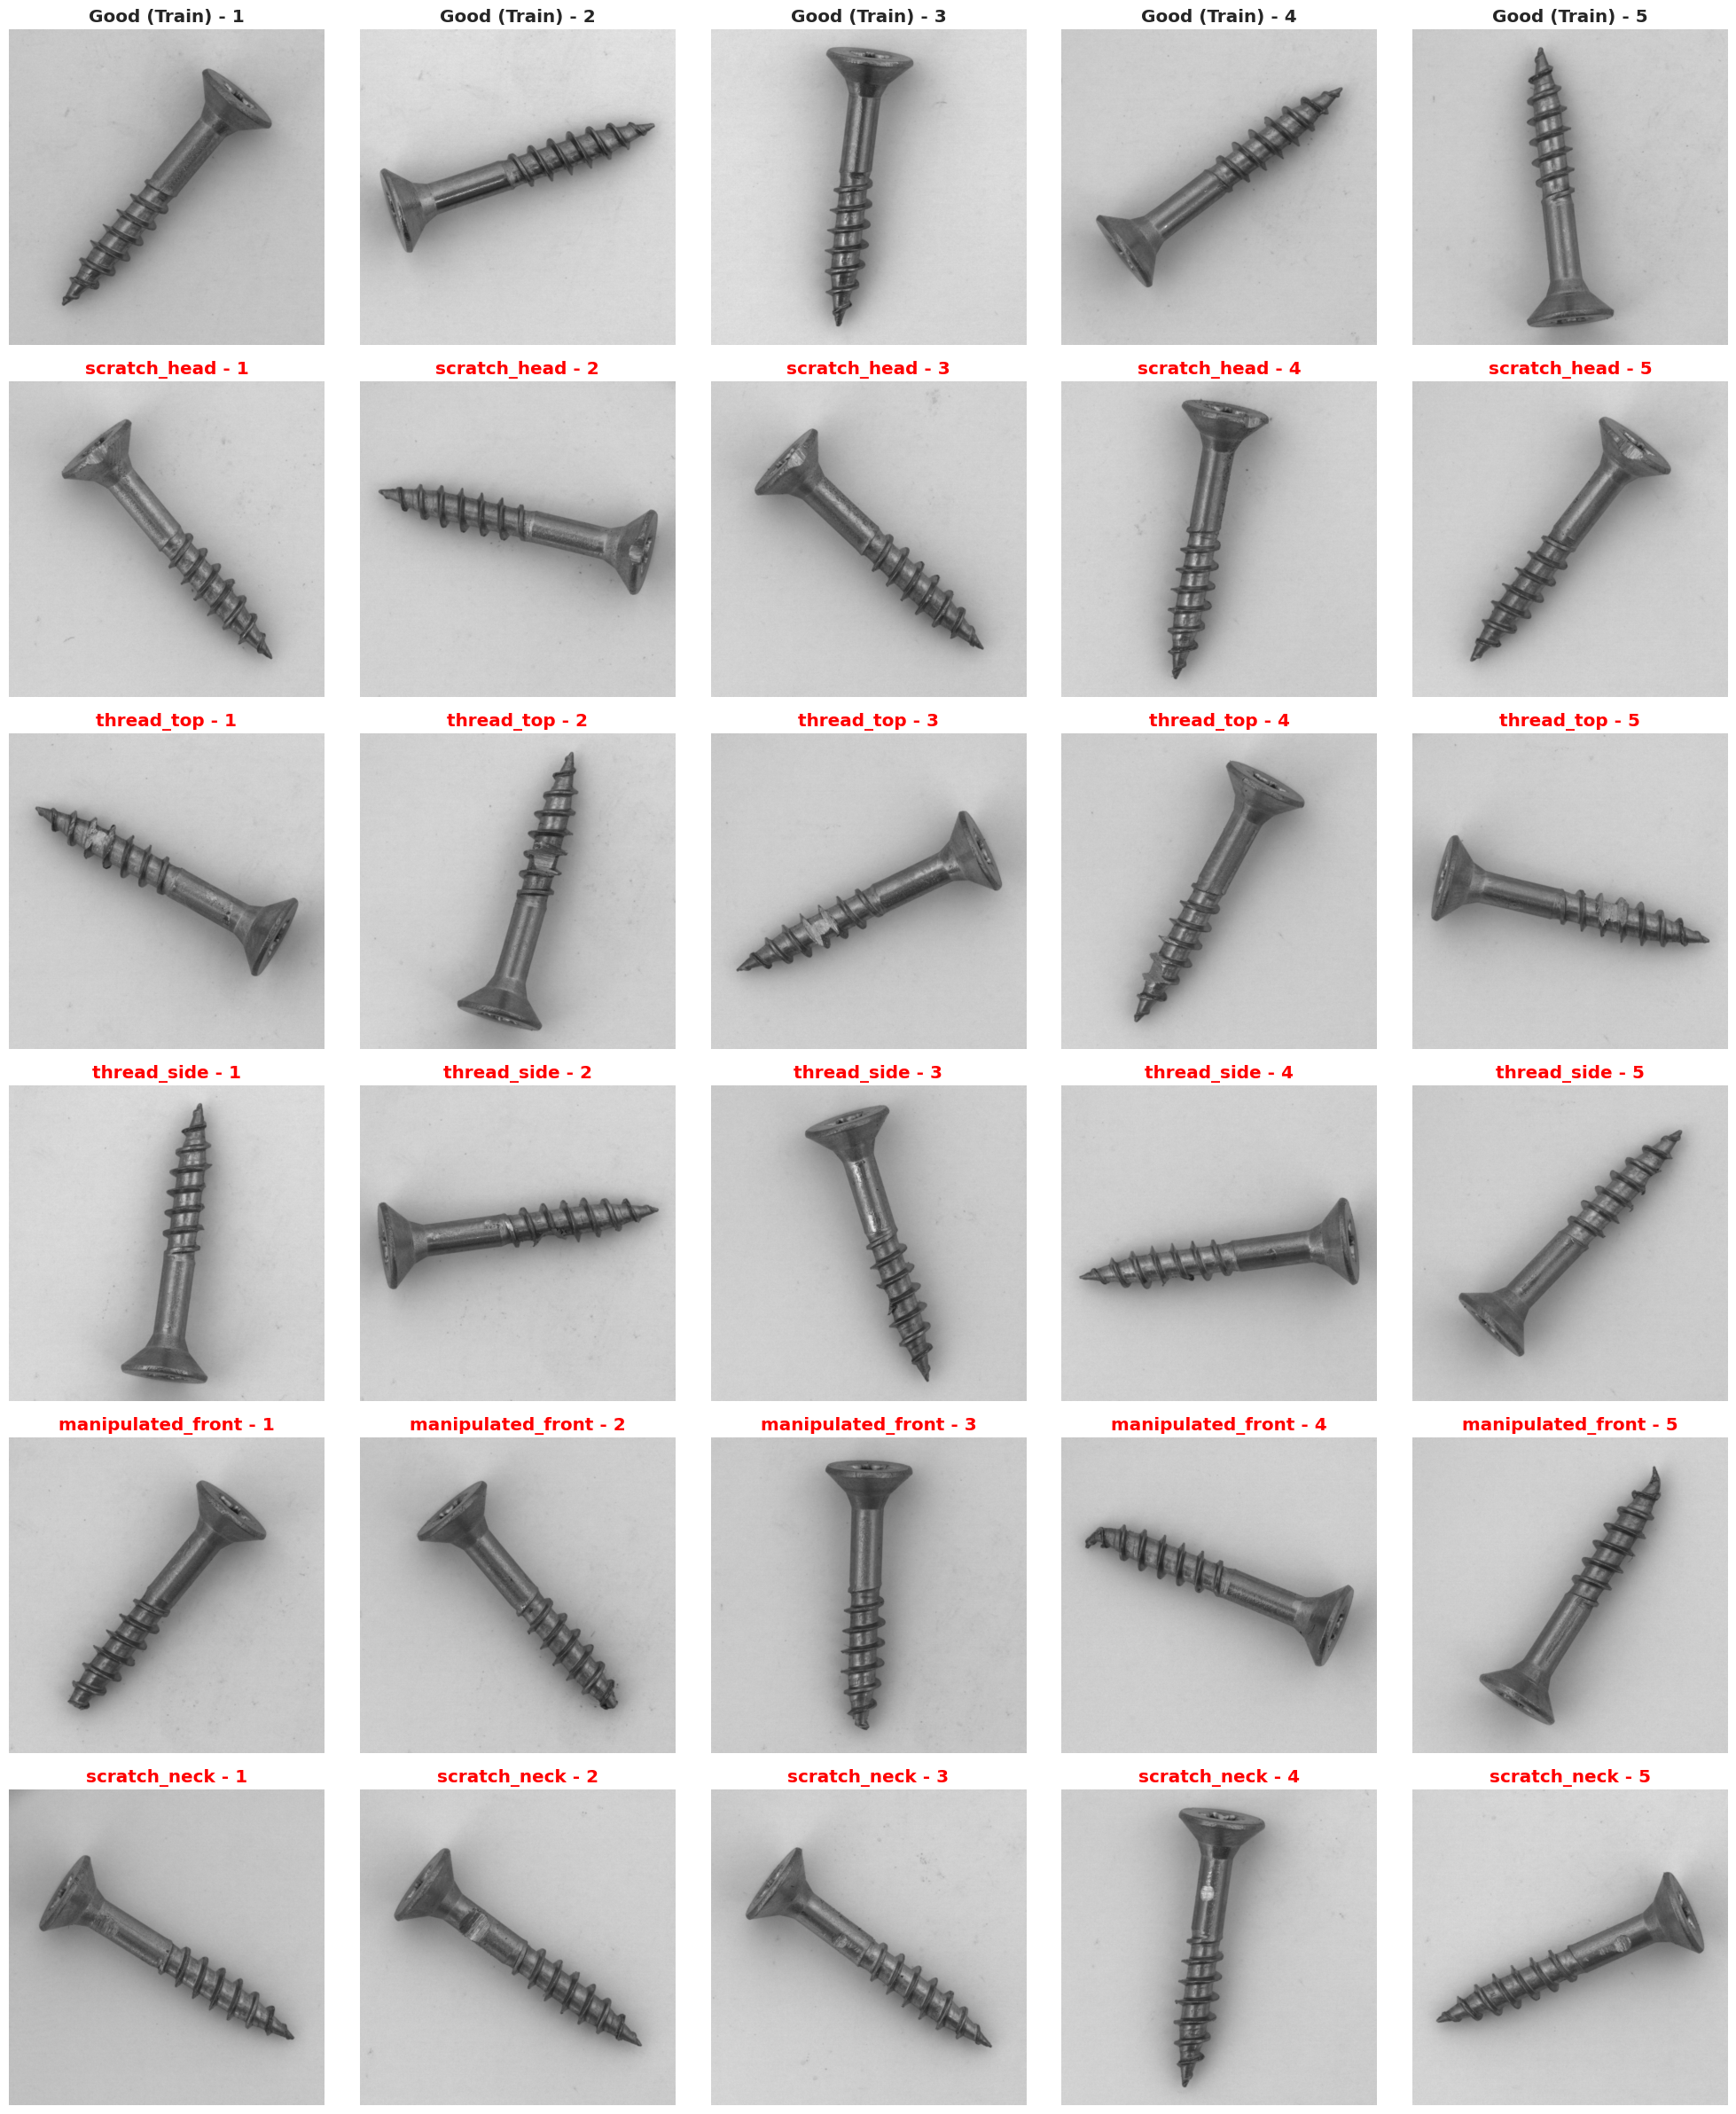

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 12

# Paths
DATA_PATH = Path("../data/raw")
CATEGORY = "screw"  # Cambiar según categoría
CATEGORY_PATH = DATA_PATH / CATEGORY
EXPERIMENTS_PATH = Path("../experiments")
EXPERIMENTS_PATH.mkdir(exist_ok=True)

print(f"📁 Category: {CATEGORY}")

def explore_dataset_structure(data_path):
    """Explora estructura completa del dataset para una case dada"""
    
    train_path = data_path / "train"
    test_path = data_path / "test"
    gt_path = data_path / "ground_truth"
    
    print(f"\n{'='*60}")
    print(f"📂 ESTRUCTURA DEL DATASET")
    print(f"{'='*60}\n")
    
    # Train
    print("🟢 TRAIN SET:")
    train_stats = {}
    if train_path.exists():
        for subdir in train_path.iterdir():
            if subdir.is_dir():
                count = len(list(subdir.glob("*.png")))
                train_stats[subdir.name] = count
                print(f"  - {subdir.name}: {count} imágenes")
    
    # Test
    print("\n🔴 TEST SET:")
    test_stats = {}
    if test_path.exists():
        for subdir in test_path.iterdir():
            if subdir.is_dir():
                count = len(list(subdir.glob("*.png")))
                test_stats[subdir.name] = count
                print(f"  - {subdir.name}: {count} imágenes")
    
    # Ground Truth
    print("\n🎯 GROUND TRUTH:")
    gt_stats = {}
    if gt_path.exists():
        for subdir in gt_path.iterdir():
            if subdir.is_dir():
                count = len(list(subdir.glob("*.png")))
                gt_stats[subdir.name] = count
                print(f"  - {subdir.name}: {count} máscaras")
    
    # Totales
    total_train = sum(train_stats.values())
    total_test = sum(test_stats.values())
    
    print(f"\n{'='*60}")
    print(f"📊 RESUMEN:")
    print(f"  Total Train: {total_train}")
    print(f"  Total Test: {total_test}")
    print(f"  Total: {total_train + total_test}")
    print(f"{'='*60}\n")
    
    return train_stats, test_stats, gt_stats

train_stats, test_stats, gt_stats = explore_dataset_structure(CATEGORY_PATH)

def plot_class_distribution(train_stats, test_stats):
    """Visualiza distribución de clases"""
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Train
    if train_stats:
        axes[0].bar(train_stats.keys(), train_stats.values(), 
                    color='green', alpha=0.7)
        axes[0].set_title('Train Set Distribution', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Class')
        axes[0].set_ylabel('Number of Images')
        axes[0].tick_params(axis='x', rotation=45)
        
        for i, (k, v) in enumerate(train_stats.items()):
            axes[0].text(i, v, str(v), ha='center', va='bottom')
    
    # Test
    if test_stats:
        colors = ['green' if 'good' in k else 'red' for k in test_stats.keys()]
        axes[1].bar(test_stats.keys(), test_stats.values(), 
                    color=colors, alpha=0.7)
        axes[1].set_title('Test Set Distribution', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Class')
        axes[1].set_ylabel('Number of Images')
        axes[1].tick_params(axis='x', rotation=45)
        
        for i, (k, v) in enumerate(test_stats.items()):
            axes[1].text(i, v, str(v), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig(EXPERIMENTS_PATH / 'class_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Calcular desbalance
    if test_stats:
        good_count = test_stats.get('good', 0)
        defect_count = sum(v for k, v in test_stats.items() if k != 'good')
        ratio = defect_count / good_count if good_count > 0 else 0
        
        print(f"\n⚠️  ANÁLISIS DE DESBALANCE:")
        print(f"  Good: {good_count}")
        print(f"  Defects: {defect_count}")
        print(f"  Ratio (Defects/Good): {ratio:.2f}")
        
        if ratio < 0.5:
            print(f"  ⚠️  Dataset desbalanceado. Considerar técnicas de balanceo.")

plot_class_distribution(train_stats, test_stats)

def visualize_samples(data_path, n_samples=5):
    """Visualiza muestras representativas"""
    
    train_path = data_path / "train" / "good"
    test_path = data_path / "test"
    
    # Obtener categorías de defectos
    defect_categories = [d.name for d in test_path.iterdir() 
                         if d.is_dir() and d.name != "good"]
    
    n_rows = 1 + len(defect_categories)
    fig, axes = plt.subplots(n_rows, n_samples, figsize=(20, 4 * n_rows))
    
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    good_images = sorted(list(train_path.glob("*.png")))[:n_samples]
    for i, img_path in enumerate(good_images):
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"Good (Train) - {i+1}", fontweight='bold')
        axes[0, i].axis('off')
    
    # Defect
    for row_idx, defect_cat in enumerate(defect_categories, start=1):
        defect_path = test_path / defect_cat
        defect_images = sorted(list(defect_path.glob("*.png")))[:n_samples]
        
        for i, img_path in enumerate(defect_images):
            img = cv2.imread(str(img_path))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[row_idx, i].imshow(img)
            axes[row_idx, i].set_title(f"{defect_cat} - {i+1}", 
                                       fontweight='bold', color='red')
            axes[row_idx, i].axis('off')
    
    plt.tight_layout()
    plt.savefig(EXPERIMENTS_PATH / 'samples_visualization.png', 
                dpi=150, bbox_inches='tight')
    plt.show()

visualize_samples(CATEGORY_PATH, n_samples=5)


In [ ]:
def analyze_all_categories(data_path):
    """Analiza todas las categorías del dataset"""
    
    # Obtener todas las categorías disponibles
    categories = [d.name for d in data_path.iterdir() 
                  if d.is_dir() and not d.name.startswith('.')]
    categories = sorted(categories)
    
    print(f"🔍 Encontradas {len(categories)} categorías en el dataset\n")
    
    all_stats = {}
    
    for category in categories:
        category_path = data_path / category
        train_path = category_path / "train"
        test_path = category_path / "test"
        gt_path = category_path / "ground_truth"
        
        print(f"{'='*60}")
        print(f"📂 ESTRUCTURA DEL DATASET: {category.upper()}")
        print(f"{'='*60}\n")
        
        # Train 
        train_stats = {}
        print("🟢 TRAIN SET:")
        if train_path.exists():
            for subdir in sorted(train_path.iterdir()):
                if subdir.is_dir():
                    count = len(list(subdir.glob("*.png")))
                    train_stats[subdir.name] = count
                    print(f"  - {subdir.name}: {count} imágenes")
        
        # Test 
        test_stats = {}
        print("\n🔴 TEST SET:")
        if test_path.exists():
            for subdir in sorted(test_path.iterdir()):
                if subdir.is_dir():
                    count = len(list(subdir.glob("*.png")))
                    test_stats[subdir.name] = count
                    print(f"  - {subdir.name}: {count} imágenes")
        
        # Ground Truth 
        gt_stats = {}
        print("\n🎯 GROUND TRUTH:")
        if gt_path.exists():
            for subdir in sorted(gt_path.iterdir()):
                if subdir.is_dir():
                    count = len(list(subdir.glob("*.png")))
                    gt_stats[subdir.name] = count
                    print(f"  - {subdir.name}: {count} máscaras")
        else:
            print("  (No disponible)")
        
        # Resumen
        total_train = sum(train_stats.values())
        total_test = sum(test_stats.values())
        
        print(f"\n{'='*60}")
        print(f"📊 RESUMEN:")
        print(f"  Total Train: {total_train}")
        print(f"  Total Test: {total_test}")
        print(f"  Total: {total_train + total_test}")
        print(f"{'='*60}\n\n")
        
        all_stats[category] = {
            'train': train_stats,
            'test': test_stats,
            'gt': gt_stats,
            'total_train': total_train,
            'total_test': total_test
        }
    
    # Resumen global
    print(f"\n{'#'*60}")
    print(f"📈 RESUMEN GLOBAL DEL DATASET")
    print(f"{'#'*60}\n")
    
    summary_data = []
    for cat, stats in all_stats.items():
        n_defect_types = len([k for k in stats['test'].keys() if k != 'good'])
        summary_data.append({
            'Categoría': cat,
            'Train': stats['total_train'],
            'Test': stats['total_test'],
            'Total': stats['total_train'] + stats['total_test'],
            'Tipos de Defecto': n_defect_types
        })
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))
    
    print(f"\n{'='*60}")
    print(f"TOTALES:")
    print(f"  Total imágenes Train: {summary_df['Train'].sum()}")
    print(f"  Total imágenes Test: {summary_df['Test'].sum()}")
    print(f"  Total imágenes: {summary_df['Total'].sum()}")
    print(f"  Total categorías: {len(categories)}")
    print(f"{'='*60}")
    
    return all_stats, summary_df

all_stats, summary_df = analyze_all_categories(DATA_PATH)

🔍 Encontradas 15 categorías en el dataset

📂 ESTRUCTURA DEL DATASET: BOTTLE

🟢 TRAIN SET:
  - good: 209 imágenes

🔴 TEST SET:
  - broken_large: 20 imágenes
  - broken_small: 22 imágenes
  - contamination: 21 imágenes
  - good: 20 imágenes

🎯 GROUND TRUTH:
  - broken_large: 20 máscaras
  - broken_small: 22 máscaras
  - contamination: 21 máscaras

📊 RESUMEN:
  Total Train: 209
  Total Test: 83
  Total: 292


📂 ESTRUCTURA DEL DATASET: CABLE

🟢 TRAIN SET:
  - good: 224 imágenes

🔴 TEST SET:
  - bent_wire: 13 imágenes
  - cable_swap: 12 imágenes
  - combined: 11 imágenes
  - cut_inner_insulation: 14 imágenes
  - cut_outer_insulation: 10 imágenes
  - good: 58 imágenes
  - missing_cable: 12 imágenes
  - missing_wire: 10 imágenes
  - poke_insulation: 10 imágenes

🎯 GROUND TRUTH:
  - bent_wire: 13 máscaras
  - cable_swap: 12 máscaras
  - combined: 11 máscaras
  - cut_inner_insulation: 14 máscaras
  - cut_outer_insulation: 10 máscaras
  - missing_cable: 12 máscaras
  - missing_wire: 10 máscaras
